In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

import pandas as pd
import numpy as np
from tqdm import *
pd.set_option('display.max_columns', None)

import random
import warnings
import math
import json
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
warnings.filterwarnings('ignore')

In [2]:
# # Results

# # Results From Paper Metrics

# In[2]:


import forest.benchmarking.distance_measures as dm
from scipy.spatial.distance import jensenshannon as jhn
def HellingerDistance(p, q):
    n = len(p)
    sum_ = 0.0
    for i in range(n):
        sum_ += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum_)
    return result


with open("Qiskit/Experiment 1/results/saveRQ1.json","r") as file:
    RQ1C = json.load(file)

with open("Cirq/Experiment 1/results/saveRQ1.json","r") as file:
    RQ1c = json.load(file)

with open("Rigetti/Experiment 1/results/saveRQ1.json","r") as file:
    RQ1r = json.load(file)


for k in RQ1c.keys():
    RQ1C[k] = RQ1c[k]

for k in RQ1r.keys():
    RQ1C[k] = RQ1r[k]

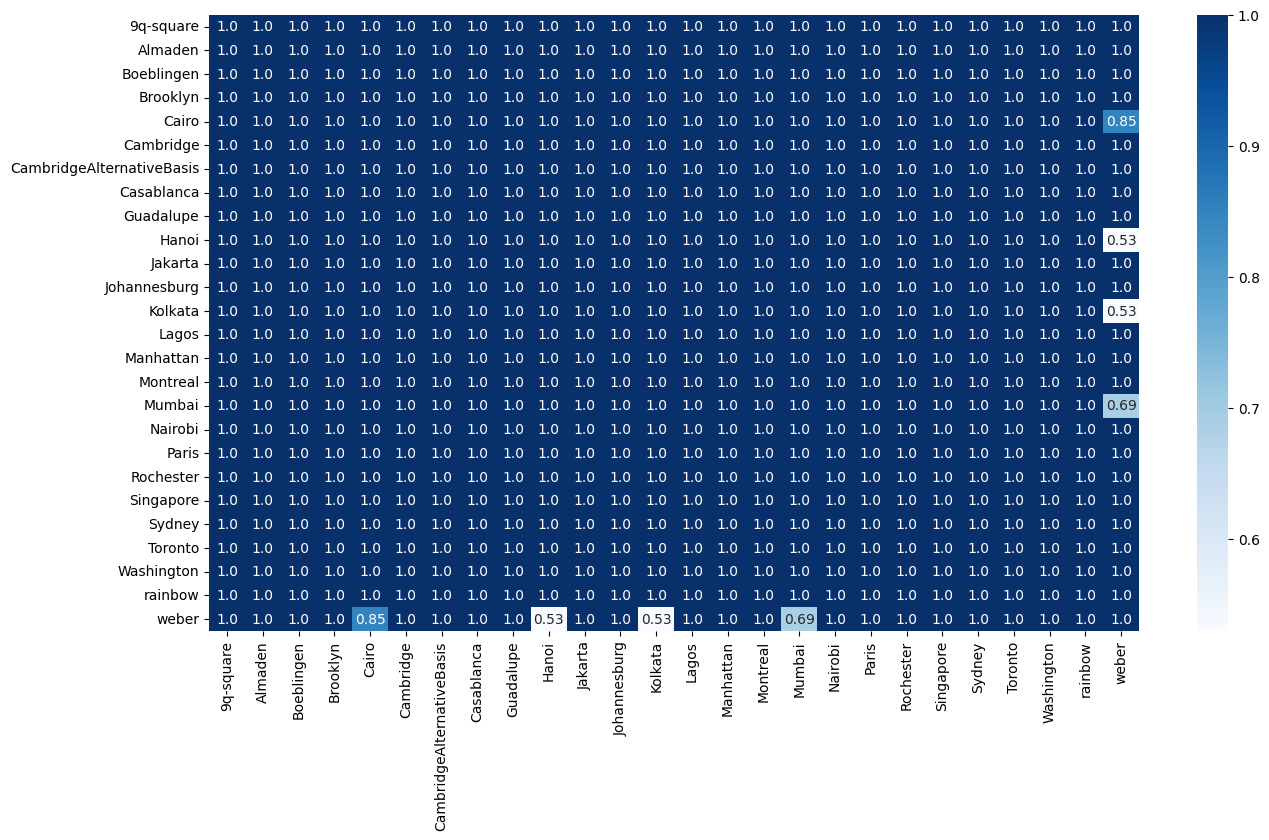

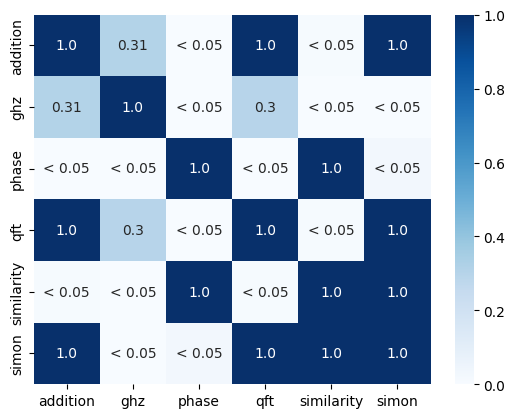

In [6]:
# In[5]:


another = {}
programs = list(RQ1C[list(RQ1C.keys())[0]].keys())
for program in programs:
    bk_tvdn = []
    bk_tvdf = []
    bk_jhnn = []
    bk_jhnf = []
    bk_hln  = []
    bk_hlf  = []
    for bk in RQ1C.keys():
        tvdn = np.mean(RQ1C[bk][program]["NoiseTVD"])
        tvdf = np.mean(RQ1C[bk][program]["FilterTVD"])
        bk_tvdn.append(tvdn)
        bk_tvdf.append(tvdf)
        jhnn = np.mean(RQ1C[bk][program]["NoiseJHN"])
        jhnf = np.mean(RQ1C[bk][program]["FilterJHN"])
        bk_jhnn.append(jhnn)
        bk_jhnf.append(jhnf)
        hln = np.mean(RQ1C[bk][program]["NoiseHL"])
        hlf = np.mean(RQ1C[bk][program]["FilterHL"])
        bk_hln.append(hln)
        bk_hlf.append(hlf)
    another[program] = {"Avg Filter TVD":np.mean(bk_tvdf),
                       "Avg Noise TVD":np.mean(bk_tvdn),
                       "Avg Filter JHN":np.mean(bk_jhnf),
                       "Avg Noise JHN":np.mean(bk_jhnn),
                       "Avg Filter HL":np.mean(bk_hlf),
                       "Avg Noise HL":np.mean(bk_hln)
                        }


# In[7]:


programs = pd.DataFrame.from_dict(another).T
programs["Improv TVD"] = np.round((programs["Avg Noise TVD"].values-programs["Avg Filter TVD"].values)/programs["Avg Noise TVD"].values*100,2)
programs["Improv JHN"] = np.round((programs["Avg Noise JHN"].values-programs["Avg Filter JHN"].values)/programs["Avg Noise JHN"].values*100,2)
programs["Improv HL"] = np.round((programs["Avg Noise HL"].values-programs["Avg Filter HL"].values)/programs["Avg Noise HL"].values*100,2)
programs[["Avg Noise HL","Avg Filter HL","Improv HL"]].to_csv("results/RQ1_HL_PP.csv")
programs[["Avg Noise HL","Avg Filter HL","Improv HL"]]


# In[8]:


another = {}

for bk in RQ1C.keys():
    bk_tvdn = []
    bk_tvdf = []
    bk_jhnn = []
    bk_jhnf = []
    bk_hln  = []
    bk_hlf  = []
    for program in RQ1C[bk].keys():
        tvdn = np.mean(RQ1C[bk][program]["NoiseTVD"])
        tvdf = np.mean(RQ1C[bk][program]["FilterTVD"])
        bk_tvdn.append(tvdn)
        bk_tvdf.append(tvdf)
        jhnn = np.mean(RQ1C[bk][program]["NoiseJHN"])
        jhnf = np.mean(RQ1C[bk][program]["FilterJHN"])
        bk_jhnn.append(jhnn)
        bk_jhnf.append(jhnf)
        hln = np.mean(RQ1C[bk][program]["NoiseHL"])
        hlf = np.mean(RQ1C[bk][program]["FilterHL"])
        bk_hln.append(hln)
        bk_hlf.append(hlf)
    another[bk.replace("Fake","")] = {"Avg Filter TVD":np.mean(bk_tvdf),
                       "Avg Noise TVD":np.mean(bk_tvdn),
                       "Avg Filter JHN":np.mean(bk_jhnf),
                       "Avg Noise JHN":np.mean(bk_jhnn),
                       "Avg Filter HL":np.mean(bk_hlf),
                       "Avg Noise HL":np.mean(bk_hln)}


# In[9]:


bk_perspective = pd.DataFrame.from_dict(another).T
bk_perspective["Improv TVD"] = np.round((bk_perspective["Avg Noise TVD"].values-bk_perspective["Avg Filter TVD"].values)/bk_perspective["Avg Noise TVD"].values*100,2)
bk_perspective["Improv JHN"] = np.round((bk_perspective["Avg Noise JHN"].values-bk_perspective["Avg Filter JHN"].values)/bk_perspective["Avg Noise JHN"].values*100,2)
bk_perspective["Improv HL"] = np.round((bk_perspective["Avg Noise HL"].values-bk_perspective["Avg Filter HL"].values)/bk_perspective["Avg Noise HL"].values*100,2)
bk_perspective[["Avg Filter HL","Avg Noise HL","Improv HL"]].sort_index().round(2).to_csv("results/RQ1_HL_BP.csv")
bk_perspective[["Avg Filter HL","Avg Noise HL","Improv HL"]].sort_index().round(2)


# # For Filter STATISTICS

# # For HL (Backend perspective)

# In[10]:


import pingouin as pg
import scikit_posthocs as sp

with open("results/RQ1_statistics.txt","w") as file:

    data = pd.DataFrame(columns=["Backend","Distance"])
    backends = []
    distance = []

    for bk in RQ1C.keys():
        dist = []
        for program in RQ1C[bk].keys():
            tvdf = np.mean(RQ1C[bk][program]["FilterHL"])
            dist.append(tvdf)

        dist = np.round(dist,2)
        backends.extend([bk.replace("Fake","") for x in dist])
        distance.extend(dist)
    data["Backend"] = backends
    data["Distance"] = distance


    result = pg.kruskal(data,dv="Distance",between="Backend")
    n = data["Distance"].shape[0]
    H = result.H[0]
    effect = H*((n+1)/(n**2-1))
    mag = ""
    if effect>=0.00 and effect < 0.01:
        mag = "Negligible"
    elif effect>=0.01 and effect < 0.04:
        mag = 'Weak'
    elif effect>=0.04 and effect < 0.16:
        mag = "Moderate"
    elif effect>=0.16 and effect < 0.36:
        mag = "Relatively strong"
    elif effect>=0.36 and effect < 0.64:
        mag = "Strong"
    elif effect>=0.64 and effect < 1.00:
        mag = "Very strong"

    file.write("For Backend Aspect: pvalue = {}, Effect size = {}, Magnitude = {}\n".format(result["p-unc"][0],effect,mag))
    
    
    result = sp.posthoc_dunn(data,val_col="Distance",group_col="Backend", p_adjust = 'bonferroni')
    result = result.round(2)
    
    text = []
    for i in result.index:
        temp = []
        for col in result.columns:
            if result.loc[i,col]<0.05:
                temp.append("< 0.05")
            else:
                temp.append(str(result.loc[i,col]))
        text.append(temp)

    plt.figure(figsize=(15,8))
    sns.heatmap(result, annot=np.array(text),fmt = '',cmap="Blues")
    plt.savefig('./results/RQ1_dunns_BP.png',bbox_inches='tight',dpi=600)
    
    
    Programs = list(RQ1C[list(RQ1C.keys())[0]].keys())
    data = pd.DataFrame()
    to_check = []
    programs = []
    distance = []

    for program in Programs:
        dist = []
        for bk in RQ1C.keys():
            tvdf = np.mean(RQ1C[bk][program]["FilterHL"])
            dist.append(tvdf)

        dist = np.round(dist,2)
        programs.extend([program for x in dist])
        distance.extend(dist)
    data["Programs"] = programs
    data["Distance"] = distance

    result = pg.kruskal(data,dv="Distance",between="Programs")
    n = data["Distance"].shape[0]
    H = result.H[0]
    effect = H*((n+1)/(n**2-1))
    mag = ""
    if effect>=0.00 and effect < 0.01:
        mag = "Negligible"
    elif effect>=0.01 and effect < 0.04:
        mag = 'Weak'
    elif effect>=0.04 and effect < 0.16:
        mag = "Moderate"
    elif effect>=0.16 and effect < 0.36:
        mag = "Relatively strong"
    elif effect>=0.36 and effect < 0.64:
        mag = "Strong"
    elif effect>=0.64 and effect < 1.00:
        mag = "Very strong"

    file.write("For Program Aspect: pvalue = {}, Effect size = {}, Magnitude = {}\n".format(result["p-unc"][0],effect,mag))
    
    
    plt.figure()
    result = sp.posthoc_dunn(data,val_col="Distance",group_col="Programs", p_adjust = 'bonferroni')
    result = result.round(2)
    
    text = []
    for i in result.index:
        temp = []
        for col in result.columns:
            if result.loc[i,col]<0.05:
                temp.append("< 0.05")
            else:
                temp.append(str(result.loc[i,col]))
        text.append(temp)


    # In[15]:


    sns.heatmap(result, annot=np.array(text),fmt = '',cmap="Blues")
    plt.savefig('./results/RQ1_dunns_PP.png',bbox_inches='tight',dpi=600)